In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

import torch
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.set_printoptions(suppress=True)

import os
import scanpy as sc
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

from scipy.sparse import load_npz

### Create & Filter clonal info

In [2]:
clones = load_npz('./clone_meta.npz').todense()
clones = pd.DataFrame(data=clones, index=[str(i) for i in range(clones.shape[0])])
clones.shape

(130887, 5864)

In [3]:
adata = sc.read_h5ad('./klein_paga.h5ad')

In [4]:
clones = clones.loc[adata.obs.index]
clones.shape

(126861, 5864)

In [5]:
temp = []
for i in list(adata.obs.index):
    try:
        temp.append('clone_' + str(np.array(clones.loc[i]).nonzero()[0][0]))
    except:
        temp.append('nan')
adata.obs['clone'] = temp

In [6]:
prog = ['prog_1', 'prog_2', 'prog_3', 'prog_4']
temp = []
for i in list(adata.obs.index):
    if adata.obs['label_man'][i] in prog:
        temp.append('progenitors')
    else:
        temp.append(adata.obs['label_man'][i])
adata.obs['label_man'] = np.array(temp)

In [7]:
for i, row in adata.obs.iterrows():
    if row['label_man'] == 'prog_Meg_Ery':
        adata.obs.at[i, 'label_man'] = 'prog_Meg_Ery_Mast'
    if row['label_man'] == 'prog_Baso_Meg_Ery_Mast':
        adata.obs.at[i, 'label_man'] = 'prog_Baso_Eos_Mast'
    if row['label_man'] == 'prog_DC_Mono':
        adata.obs.at[i, 'label_man'] = 'prog_mDC'
    if row['label_man'] == 'DC':
        adata.obs.at[i, 'label_man'] = 'mDC'

In [8]:
adata.obs['pop_time'] = [adata.obs['label_man'][i] + '_Day' + str(int(adata.obs['Time_point'][i])) for i in list(adata.obs.index)]

In [9]:
adata.obs

Time_point Population  Annotation  Well time_cat leiden  \
0              6.0         LK      undiff     2      6.0     16   
1              6.0         LK      undiff     2      6.0     10   
2              6.0         LK    Monocyte     2      6.0      3   
3              6.0         LK  Neutrophil     2      6.0     12   
4              6.0         LK      undiff     2      6.0      9   
...            ...        ...         ...   ...      ...    ...   
130882         6.0        LSK      undiff     1      6.0     10   
130883         6.0        LSK      undiff     1      6.0      0   
130884         6.0        LSK    Monocyte     1      6.0      2   
130885         6.0        LSK    Monocyte     1      6.0      2   
130886         6.0        LSK      undiff     1      6.0     15   

                 comb           label_man       clone                 pop_time  
0           undiff_16         progenitors   clone_573         progenitors_Day6  
1           undiff_10  prog_Baso_Eos_Mast  clone_1440  prog_Baso_Eos_Mast_Day6  
2          Monocyte_3           prog_Mono   clone_394           prog_Mono_Day6  
3       Neutrophil_12      early_prog_Neu         nan      early_prog_Neu_Day6  
4            undiff_9   prog_Meg_Ery_Mast  clone_1972   prog_Meg_Ery_Mast_Day6  
...               ...                 ...         ...                      ...  
130882      undiff_10  prog_Baso_Eos_Mast         nan  prog_Baso_Eos_Mast_Day6  
130883       undiff_0         progenitors  clone_1374         progenitors_Day6  
130884     Monocyte_2                Mono         nan                Mono_Day6  
130885     Monocyte_2                Mono         nan                Mono_Day6  
130886      undiff_15         progenitors         nan         progenitors_Day6  

[126861 rows x 10 columns]

In [10]:
set(adata.obs['label_man'].values)

{'Baso',
 'Eos',
 'Ery',
 'Ly',
 'Mast',
 'Meg',
 'Mono',
 'Neu',
 'early_prog_Neu',
 'mDC',
 'pDC',
 'prog_Baso_Eos',
 'prog_Baso_Eos_Mast',
 'prog_Ly_pDC',
 'prog_Meg_Ery_Mast',
 'prog_Mono',
 'prog_Neu',
 'prog_mDC',
 'progenitors'}

In [11]:
adata_clones = adata[adata.obs['clone'] != 'nan', :]
adata_clones

View of AnnData object with n_obs × n_vars = 47979 × 5000
    obs: 'Time_point', 'Population', 'Annotation', 'Well', 'time_cat', 'leiden', 'comb', 'label_man', 'clone', 'pop_time'
    var: 'symbol', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Annotation_colors', 'comb_colors', 'hvg', 'label_man_colors', 'label_man_sizes', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'paga', 'pca', 'time_cat_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [12]:
from natsort import natsorted
clone_index = list(set(adata_clones.obs['clone'].values))
columns = list(set(adata_clones.obs['pop_time'].values))
mat = pd.DataFrame(index=natsorted(clone_index), columns=natsorted(columns), data=0.0)

In [13]:
for idx, row in adata_clones.obs.iterrows():
    mat.at[row['clone'], row['pop_time']] += 1

In [14]:
print (mat.sum().sum())
print (mat[[i for i in mat.columns if i.endswith('Day2')]].sum().sum())
print (adata[adata.obs['Time_point'].values == 2.0, :].shape)
print (mat[[i for i in mat.columns if i.endswith('Day4')]].sum().sum())
print (adata[adata.obs['Time_point'].values == 4.0, :].shape)
print (mat[[i for i in mat.columns if i.endswith('Day6')]].sum().sum())
print (adata[adata.obs['Time_point'].values == 6.0, :].shape)

47979.0
4558.0
(27757, 5000)
14679.0
(47444, 5000)
28742.0
(51660, 5000)


### Analysis of clonal info

In [15]:
mat = sc.AnnData(mat, dtype=np.float32)
mat

AnnData object with n_obs × n_vars = 5859 × 55

In [16]:
sc.pp.filter_cells(mat, min_counts=5)
sc.pp.filter_genes(mat, min_counts=1)
mat

AnnData object with n_obs × n_vars = 2770 × 51
    obs: 'n_counts'
    var: 'n_counts'

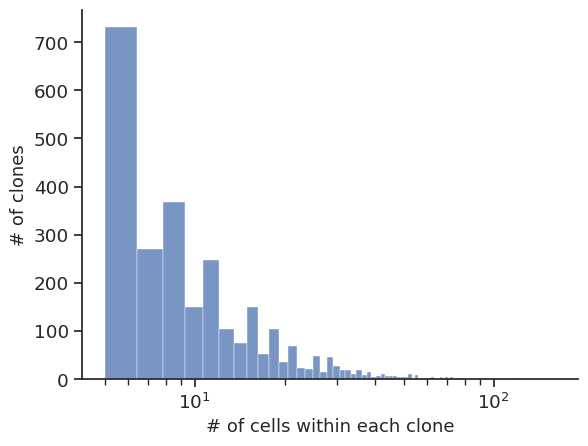

In [18]:
sns.set_theme(style='ticks', font_scale=1.2)
ax = sns.histplot(mat.obs.n_counts.values)
plt.xscale('log')
plt.xlabel('# of cells within each clone', fontsize=13)
plt.ylabel('# of clones', fontsize=13)
ax.spines[['right', 'top']].set_visible(False)
plt.savefig('./cellnumber.svg', dpi=600, bbox_inches='tight', transparent=False, facecolor='white')

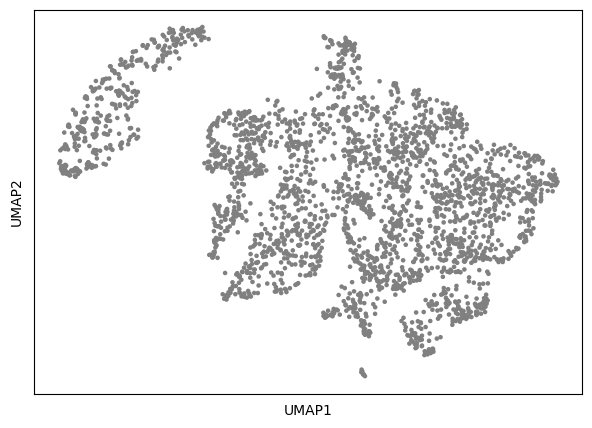

In [17]:
sc.tl.pca(mat)
sc.pp.neighbors(mat, n_neighbors=25)
sc.tl.umap(mat)
sc.pl.scatter(mat, basis='umap')

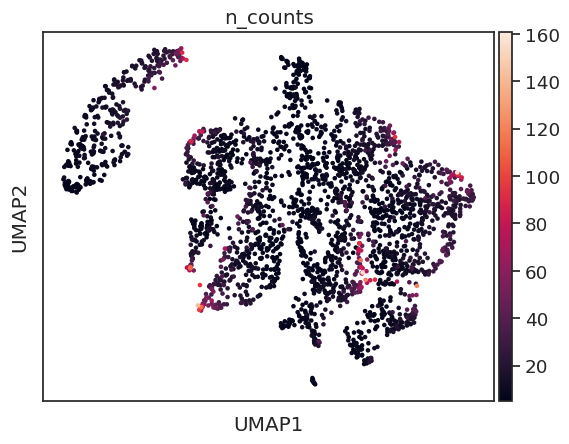

In [20]:
sc.pl.umap(mat, color='n_counts', legend_loc='on data')

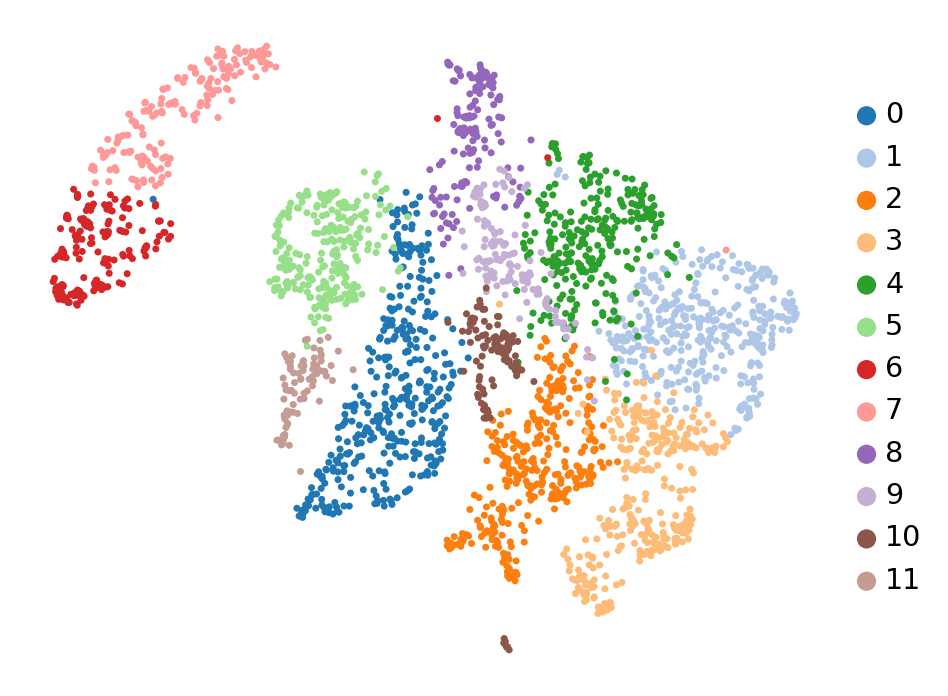

In [19]:
sc.set_figure_params(dpi_save=600, format='svg', figsize=(6, 5))
sc.tl.leiden(mat, resolution=.5)
sc.pl.scatter(mat, basis='umap', color='leiden', legend_loc='right margin', size=40, save='leiden.svg', title='', frameon=False, palette=sns.color_palette('tab20'))

In [20]:
mat.obs.leiden.value_counts()

0     387
1     377
2     315
3     306
4     277
5     252
6     188
7     173
8     161
9     139
10    109
11     86
Name: leiden, dtype: int64

### UMAP related plots

In [21]:
mat.obs

n_counts leiden
clone_0          5.0      8
clone_1         20.0      2
clone_2         15.0      2
clone_4          9.0      0
clone_5          5.0      1
...              ...    ...
clone_5845      24.0      5
clone_5848      12.0      6
clone_5850      11.0      4
clone_5857      14.0      3
clone_5858       7.0      3

[2770 rows x 2 columns]

In [22]:
adata_clones_filter = adata_clones[[i in list(mat.obs.index) for i in adata_clones.obs['clone']], :]
adata_clones_filter

View of AnnData object with n_obs × n_vars = 39865 × 5000
    obs: 'Time_point', 'Population', 'Annotation', 'Well', 'time_cat', 'leiden', 'comb', 'label_man', 'clone', 'pop_time'
    var: 'symbol', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Annotation_colors', 'comb_colors', 'hvg', 'label_man_colors', 'label_man_sizes', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'paga', 'pca', 'time_cat_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

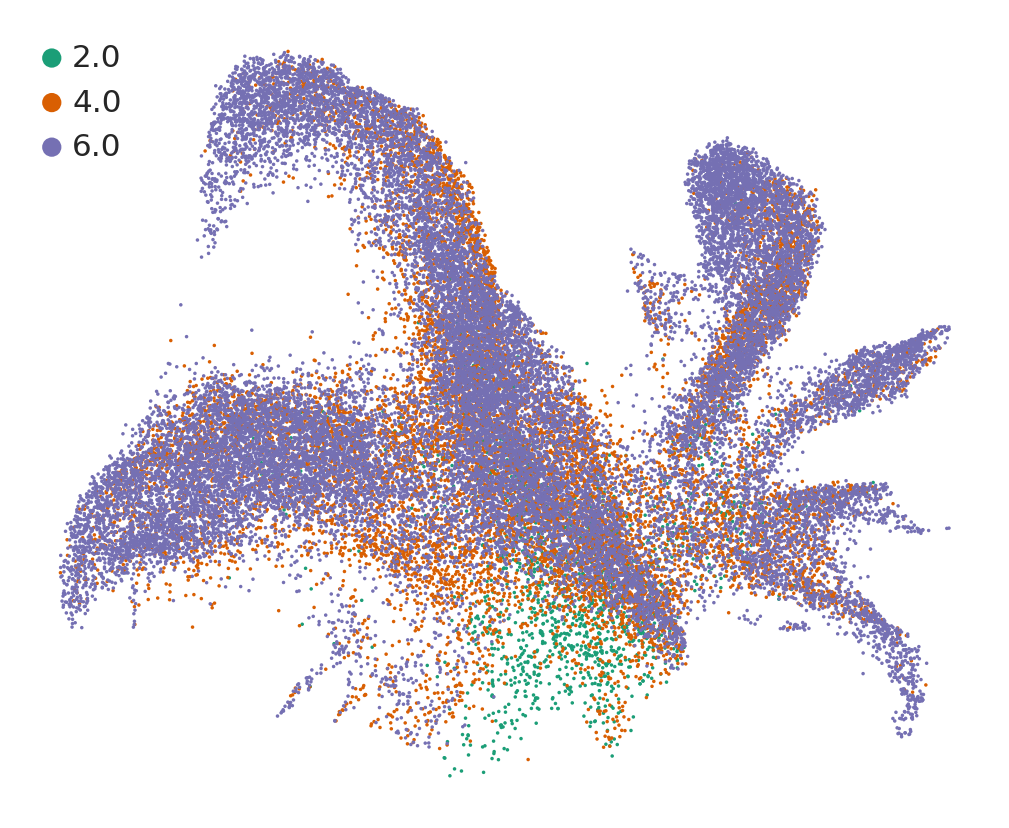

In [27]:
sc.set_figure_params(dpi_save=600, format='svg', figsize=(7, 6))
sc.pl.scatter(adata_clones_filter, basis='umap', color='time_cat', 
              legend_loc='upper left', palette=sns.color_palette('Dark2'), 
              save='timepoints.svg', size=10, frameon=False, title='',
              legend_fontsize=14)

In [24]:
leiden = []
for clone in adata_clones_filter.obs['clone'].values:
    leiden.append(mat.obs.loc[clone.lower()]['leiden'])
adata_clones_filter.obs['Meta clones'] = leiden

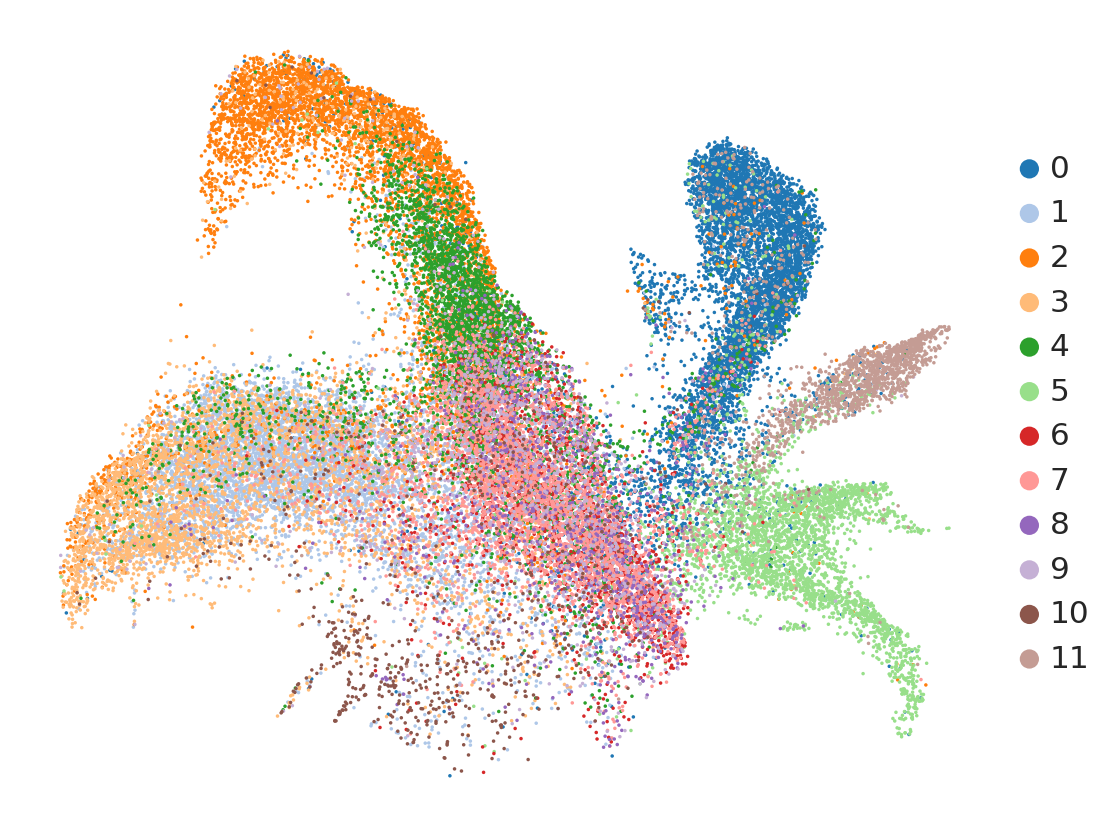

In [28]:
sc.set_figure_params(dpi_save=600, format='svg', figsize=(7, 6))
sc.pl.scatter(adata_clones_filter, basis='umap', color='Meta clones', 
              legend_loc='right margin', palette=sns.color_palette('tab20'), 
              save='metaclones.svg', size=10, frameon=False,
              title='', legend_fontsize=14)

In [25]:
progenitors = adata_clones_filter[adata_clones_filter.obs['label_man'] == 'progenitors', :]
progenitors = progenitors[progenitors.obs['time_cat'] == 2.0, :]
progenitors

View of AnnData object with n_obs × n_vars = 1191 × 5000
    obs: 'Time_point', 'Population', 'Annotation', 'Well', 'time_cat', 'leiden', 'comb', 'label_man', 'clone', 'pop_time', 'Meta clones'
    var: 'symbol', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Annotation_colors', 'comb_colors', 'hvg', 'label_man_colors', 'label_man_sizes', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'paga', 'pca', 'time_cat_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

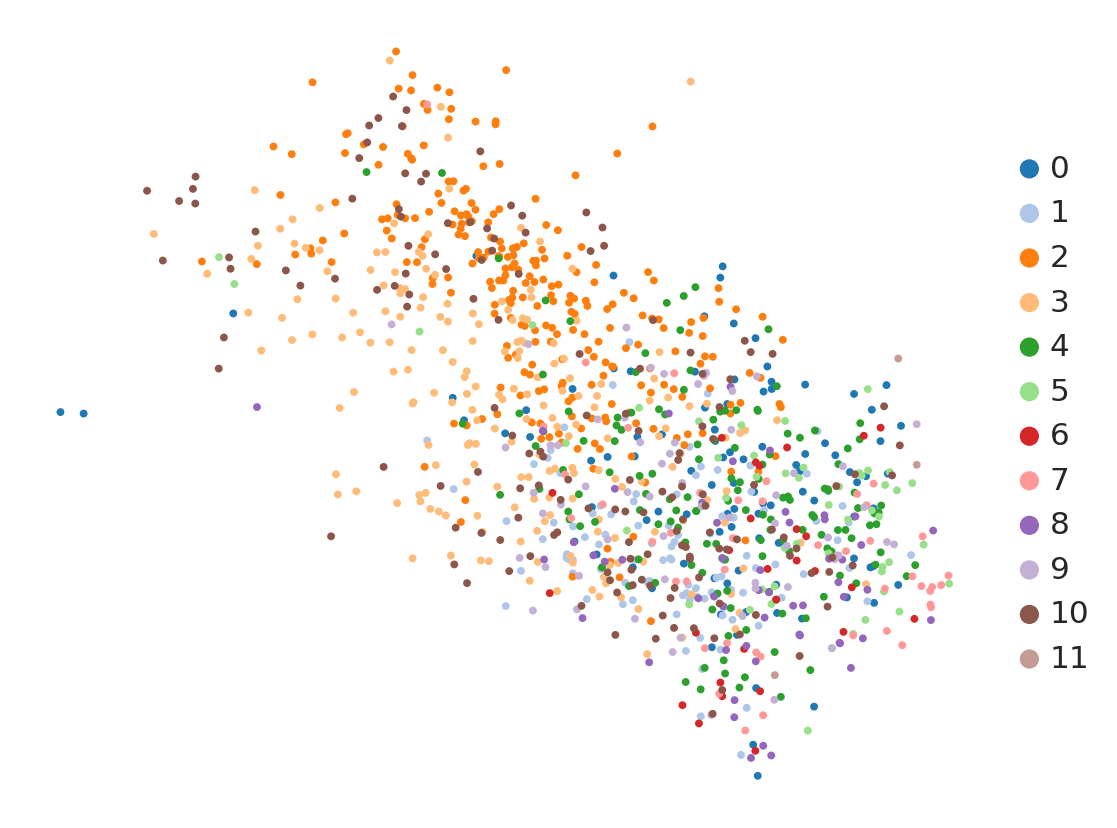

In [34]:
sc.set_figure_params(dpi_save=600, format='svg', figsize=(7, 6))
sc.pl.scatter(progenitors, basis='umap', color='Meta clones', 
              legend_loc='right margin', palette=sns.color_palette('tab20'), 
              save='progenitors.svg', size=50, frameon=False,
              title='', legend_fontsize=14)

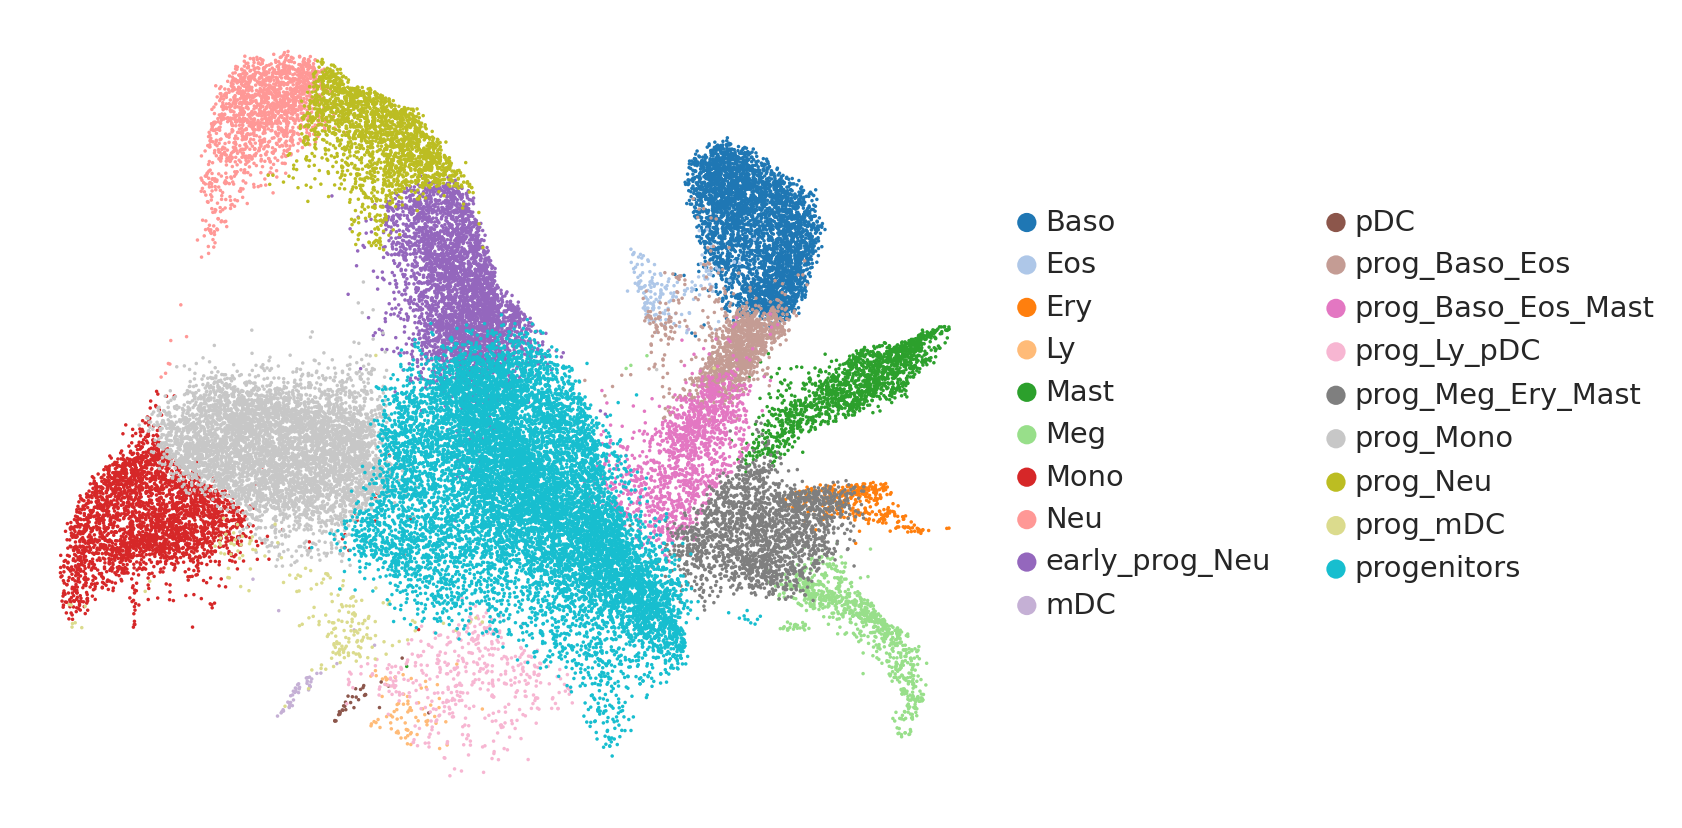

In [36]:
sc.set_figure_params(dpi_save=600, format='svg', figsize=(7, 6))
sc.pl.scatter(adata_clones_filter, basis='umap', color='label_man', 
              legend_loc='right margin', palette=sns.color_palette('tab20'), 
              save='populations.svg', size=10, frameon=False, 
              title='', legend_fontsize=13)

/data/users/mingzegao/.conda/envs/pytorch/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


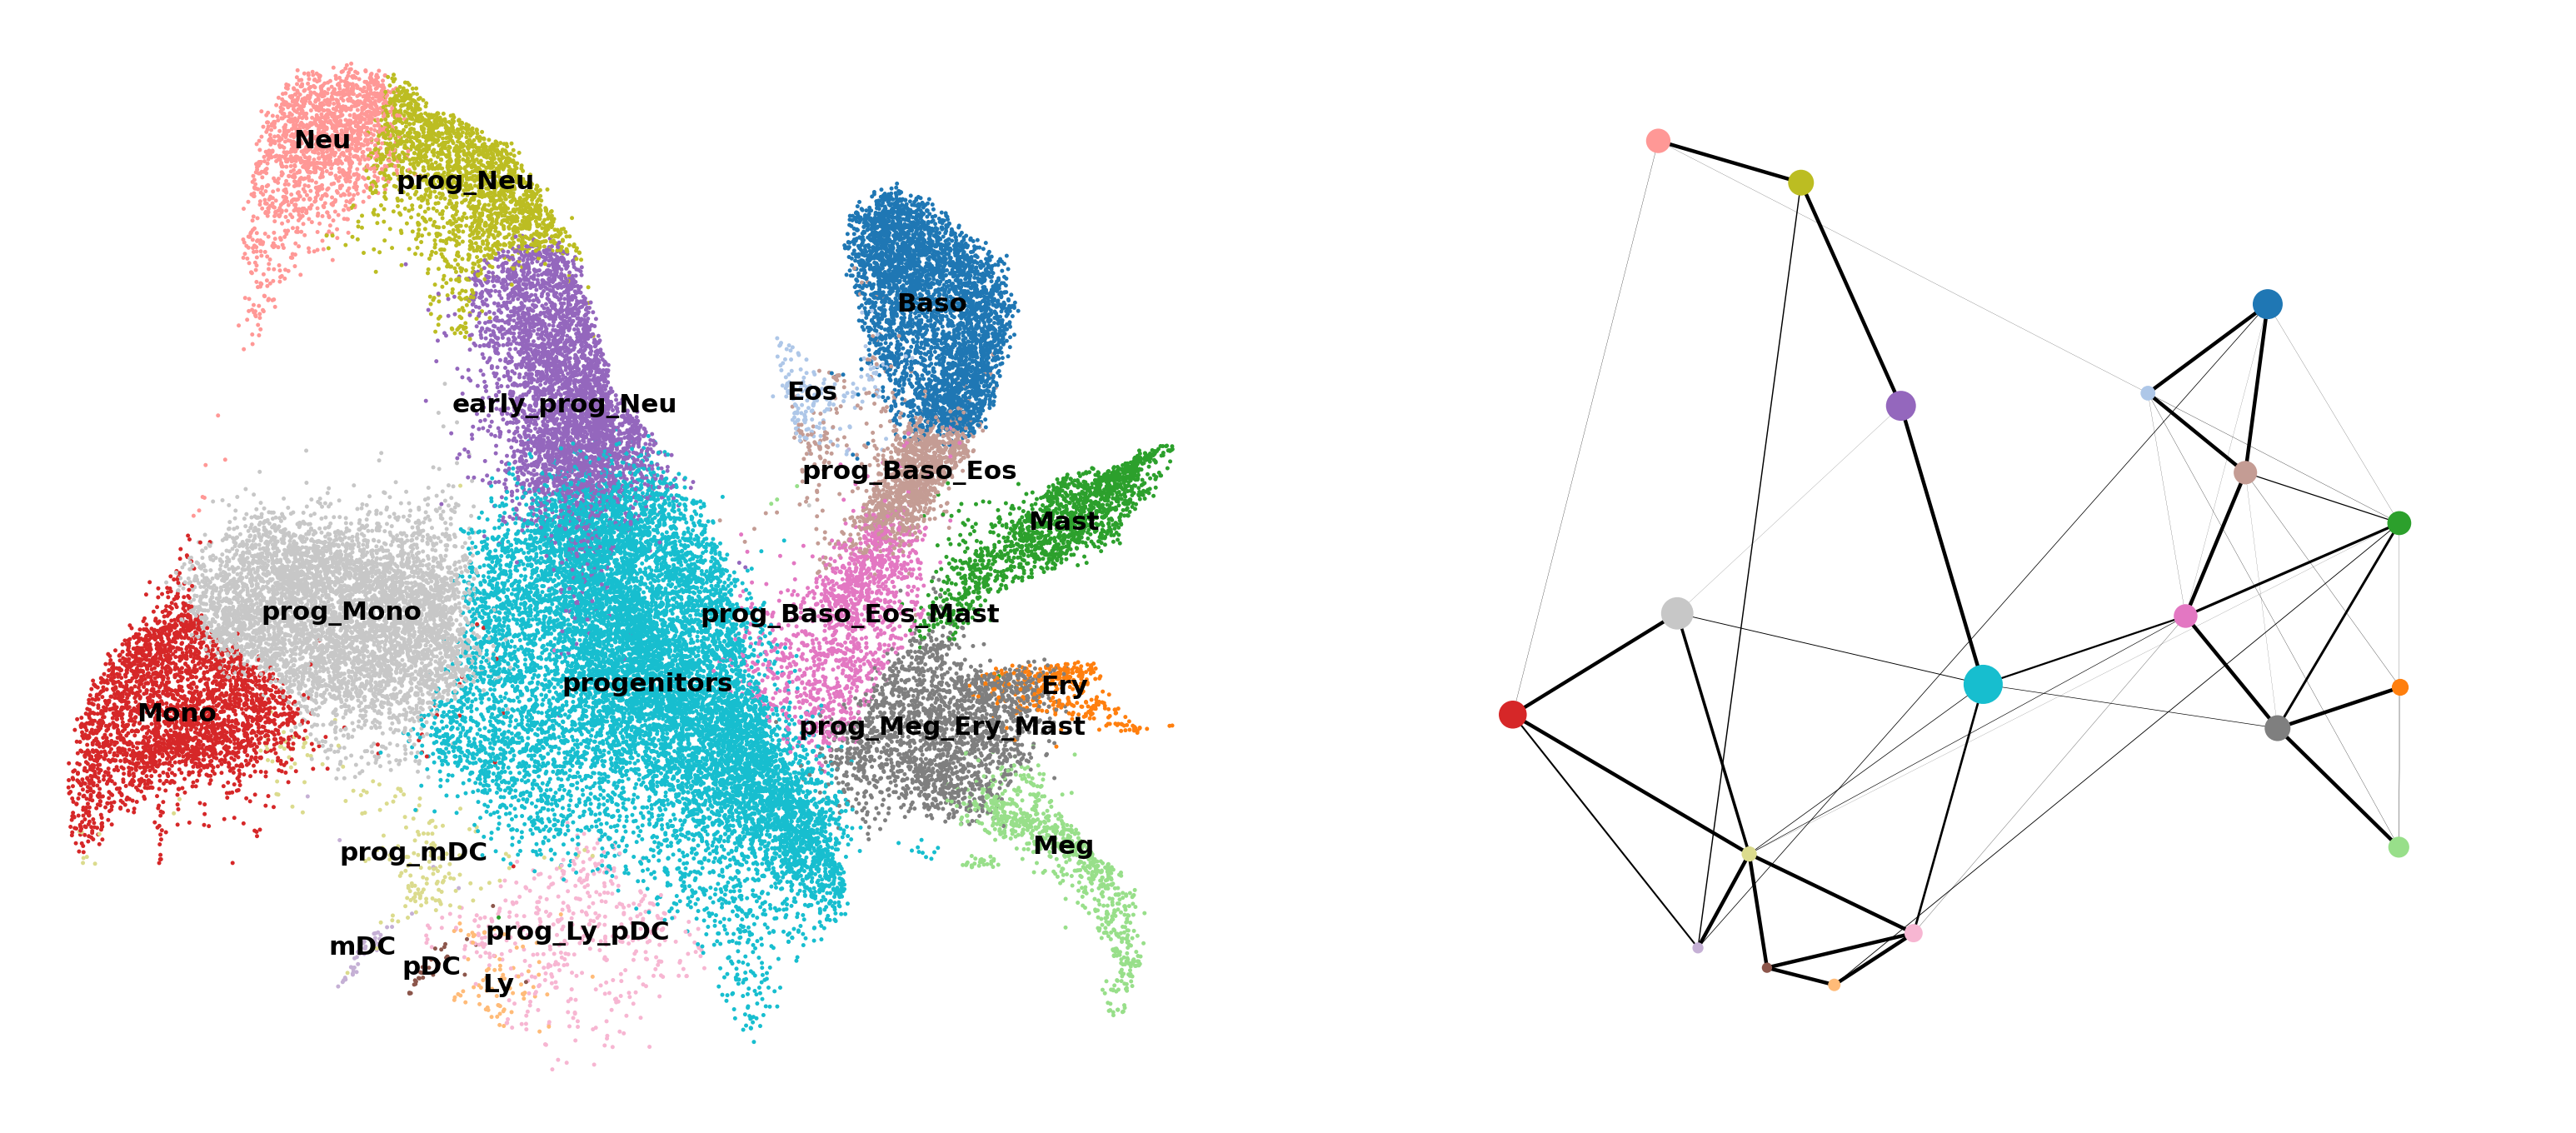

In [26]:
sc.set_figure_params(dpi_save=600, format='svg', figsize=(10, 10))
sc.tl.paga(adata_clones_filter, groups='label_man')
sc.pl.paga_compare(
    adata_clones_filter, basis='umap', palette=sns.color_palette('tab20'), 
    save='_supplement_paga.svg', size=20, frameon=False, 
    title='', edge_width_scale=0.75, max_edge_width=2, 
    labels=['' for i in range(len(set(adata_clones_filter.obs['label_man'])))]
)

In [27]:
adata.obs['Meta clones'] = np.zeros(adata.shape[0]) - 1
for i in list(adata_clones_filter.obs.index):
    adata.obs.at[i, 'Meta clones'] = adata_clones_filter.obs.loc[i]['Meta clones']
adata.obs['Meta clones'] = [str(i) for i in adata.obs['Meta clones']]

In [28]:
adata.write('./adata_megas.h5ad')

### Generate model inputs

In [29]:
times = [2, 4, 6]
size_leiden = len(set(mat.obs.leiden))
size_time = len(times)
size_pops = len(set(adata.obs.label_man))
print (size_leiden, size_time, size_pops)

12 3 19


In [30]:
from natsort import natsorted
leiden = list(set(mat.obs.leiden))
leiden = natsorted(leiden)
leiden

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']

In [31]:
df = pd.DataFrame(data=mat.X, columns=list(mat.var.index), index=list(mat.obs.index))
df.loc[:, df.columns.str.endswith('_Day2')] = df.loc[:, df.columns.str.endswith('_Day2')] * 60000 / 4558
df.loc[:, df.columns.str.endswith('_Day4')] = df.loc[:, df.columns.str.endswith('_Day4')] * 128972 * (60000 / 32243) / 14679
df.loc[:, df.columns.str.endswith('_Day6')] = df.loc[:, df.columns.str.endswith('_Day6')] * 163056 * (128972 / 81528) * (60000 / 32243) / 28742
df = df.round(0)

In [32]:
df = sc.AnnData(df, dtype=np.float32)
df

AnnData object with n_obs × n_vars = 2770 × 51

In [34]:
kinetics = np.zeros((size_leiden + 1, size_time, size_pops), dtype=np.float32)
pops = ['progenitors', 'prog_Baso_Eos_Mast', 'prog_Ly_pDC', 'prog_Baso_Eos', 
        'prog_mDC', 'prog_Mono', 'prog_Meg_Ery_Mast', 'early_prog_Neu', 'prog_Neu', 
        'Baso', 'Eos', 'pDC', 'mDC', 'Mono', 'Ly', 'Meg', 'Ery', 'Mast', 'Neu']

for idi, leid in enumerate(leiden):
    for idj, time in enumerate(times):
        for idk, pop in enumerate(pops):
            if pop + '_Day' + str(time) in mat.var_names:
                kinetics[idi, idj, idk] = \
                    np.array(df[mat.obs.leiden == leid, mat.var_names == (pop + '_Day' + str(time))].X).sum()

In [35]:
kinetics.sum()

655309.0

In [36]:
for idj, time in enumerate(times):
    for idk, pop in enumerate(pops):
        if pop + '_Day' + str(time) in adata.obs['pop_time'].values:
            num = adata[adata.obs['pop_time'] == (pop + '_Day' + str(time)), :].shape[0]
            if str(time) == '2':
                num *= int(60000 / 4558)
            if str(time) == '4':
                num *= int(128972 * (60000 / 32243) / 14679)
            if str(time) == '5':
                num *= int(163056 * (128972 / 81528) * (60000 / 32243) / 28742)
            kinetics[-1, idj, idk] = num

In [37]:
kinetics.sum()

1826914.0

In [38]:
np.savetxt('./kinetics_array_correction_factor.txt', np.reshape(kinetics, (size_leiden + 1, size_time * size_pops)))

In [39]:
len(set(adata.obs['clone']))

5860

<AxesSubplot: >

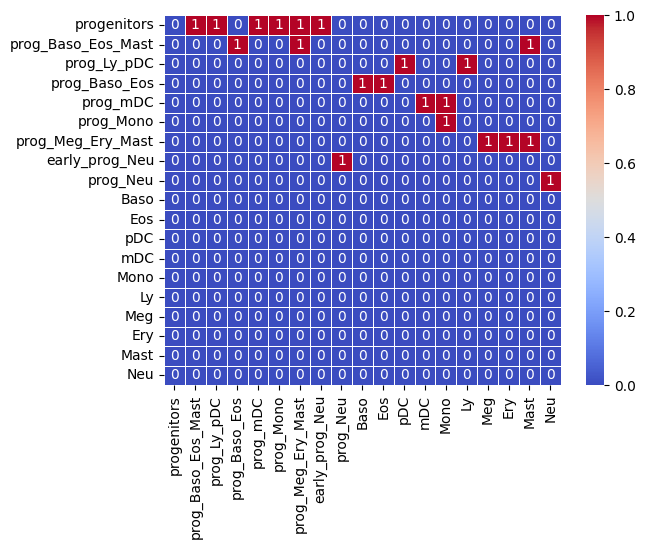

In [5]:
paga = pd.read_csv('../Weinreb_Analysis/graph_table.csv', index_col=0)
paga = paga.fillna(0.0)
import seaborn as sns
sns.heatmap(paga, annot=True, linewidth=.5, cmap='coolwarm')

In [52]:
anno = pd.DataFrame(columns=['populations'], index=['Clone ' + str(i) for i in range(paga.shape[0])])
anno['populations'] = paga.columns
anno.to_csv('./annotations.csv', index_label='clones')

### Analysis of adata object

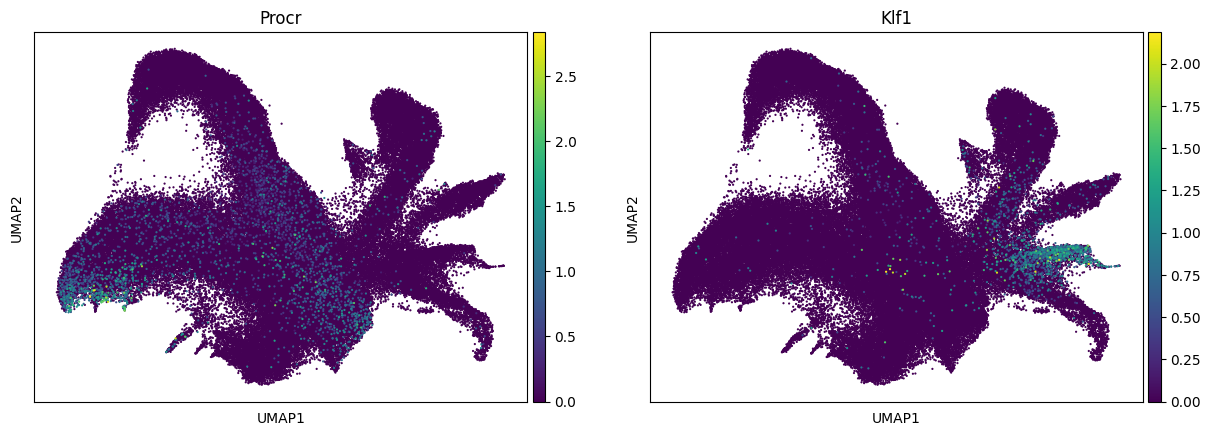

In [21]:
sc.pl.umap(adata, color=['Procr', 'Klf1'], s=10)

In [23]:
crosstab = pd.crosstab(adata.obs.leiden, adata.obs.Annotation)
crosstab

Annotation  Baso  Ccr7_DC  Eos  Erythroid  Lymphoid  Mast   Meg  Monocyte  \
leiden                                                                      
0              0        0    0          0         0     0     0         1   
1              0        0    0          0         0     0     0         2   
2              0        0    0          0         0     0     0      8481   
3              0        0    0          0         0     0     0      5819   
4           7607        0   74          0         0     0     0        12   
5              0        0    0          0       856     0     0         4   
6              0        0    0          0         0     0     0        75   
7              0        0    0          0         0     0     0         0   
8              0        0    0          0         0     0     0         0   
9              2        0    0        673         0     0   424         1   
10          2437        0    4          0         0     4     1         0   
11             1        0    0          2         0     0     0       176   
12             0        0    0          0         0     0     0         0   
13             0        0    0          0         0     0     0      4426   
14             0        0    0          0         0     0     0        32   
15             0        0    0          0         0     0     0         0   
16             2        0    0          1         0     0     0         3   
17            18        0    0          3         0  2570     1         4   
18             1        0    3          0         0     0  1661         1   
19             0      241    1          0         0     1     0         3   
20            57        0  471          1         0     3     1         1   

Annotation  Neutrophil  pDC  undiff  
leiden                               
0                    0    0   14687  
1                  667    0    8755  
2                    2    0     217  
3                   15    0    2499  
4                    7    0     245  
5                    0  100    6778  
6                    1    0    7215  
7                 6609    0       0  
8                 3038    0    3696  
9                    2    0    5534  
10                   1    0    3865  
11                 345    0    5740  
12                5935    0     141  
13                   4    0       0  
14                5366    0       0  
15                   0    0    4659  
16                   5    1    3207  
17                   1    0     523  
18                   7    0       0  
19                   2    0     588  
20                   6    0     236

/data/users/mingzegao/.conda/envs/pytorch/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/data/users/mingzegao/.conda/envs/pytorch/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/data/users/mingzegao/.conda/envs/pytorch/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


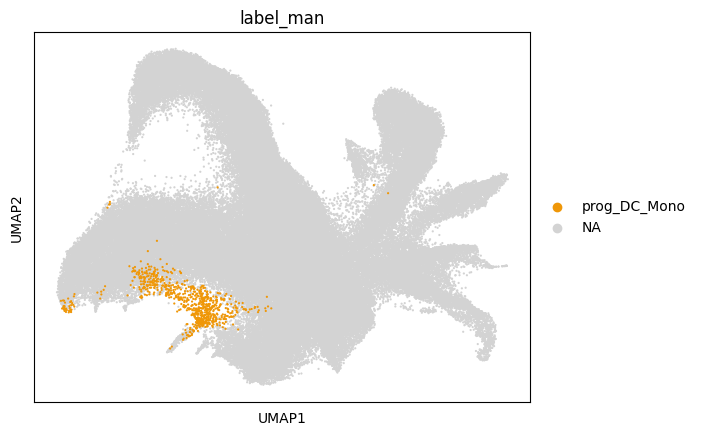

In [40]:
sc.pl.umap(adata, color=['label_man'], groups='prog_DC_Mono', s=10)